# Projeto 2º Bimestre: Otimização de Custos de Estoque (EOQ) 
Este notebook cobre a **Fase 1, Etapa 3** do roadmap: a Modelagem Matemática e Análise de <br>Otimização usando SymPy, Seaborn e Matplotlib.<br>
<br>
O objetivo é encontrar o **Lote Econômico de Compra (Q*)** que minimiza os custos totais de estoque para uma persona, considerando um modelo rigoroso com descontos por quantidade.

In [37]:
%pip install seaborn
%pip install matplotlib
%pip install sympy

import sympy as sp                # Para cálculo simbólico (derivadas)
import pandas as pd                # Para manipulação de dados (se necessário)
import seaborn as sns              # Para visualização gráfica\n",
import matplotlib.pyplot as plt    # Para plotagem e customização\n",
import numpy as np                 # Para cálculos numéricos e ranges
import math                        # Para funções matemáticas (sqrt)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1. A Prova Simbólica (Critério: Modelo Rigoroso)

Antes de resolver o problema da persona, vamos usar o `SymPy` para provar matematicamente a fórmula do EOQ. Isso demonstra o rigor na modelagem, como pedido na rubrica.

In [38]:
# 1. Definir os Símbolos
# Q = Quantidade, D = Demanda, S = Custo Pedido, H = Custo Estocagem
Q, D, S, H, P = sp.symbols('Q D S H P')

# 2. Definir a Função Objetivo Custo Total
# C_T(Q) = Custo Anual Pedido + Custo Anual Estocagem + Custo Anual Produto
C_T = (D * S / Q) + (H * Q / 2) + (D * P)

print(f"Função Custo Total Simbólica:\nC_T(Q) = {C_T}\n")

# 3. Calcular a 1ª Derivada (achar pontos críticos)
C_T_prime = sp.diff(C_T, Q)
print(f"1ª Derivada (C_T'(Q)):\n{C_T_prime}\n")

# 4. Resolver C_T'(Q) = 0 para achar o Q* (Lote Econômico)
# Pegamos a solução positiva [1]
Q_star_formula = sp.solve(C_T_prime, Q)[1]
print(f"Solução para Q* (Fórmula do EOQ):\nQ* = {Q_star_formula}\n")

# 5. Calcular a 2ª Derivada (classificar o ponto)
C_T_double_prime = sp.diff(C_T_prime, Q)
print(f"2ª Derivada (C_T''(Q)):\n{C_T_double_prime}\n")

Função Custo Total Simbólica:
C_T(Q) = D*P + D*S/Q + H*Q/2

1ª Derivada (C_T'(Q)):
-D*S/Q**2 + H/2

Solução para Q* (Fórmula do EOQ):
Q* = sqrt(2)*sqrt(D*S/H)

2ª Derivada (C_T''(Q)):
2*D*S/Q**3



### Interpretação da Prova

A 2ª Derivada é `2*D*S/Q**3`.

Dado que `D` (Demanda), `S` (Custo de Pedido) e `Q` (Quantidade) são, por definição, sempre positivos (`> 0`), o valor da 2ª derivada será **sempre positivo**.

Pelo teste da segunda derivada, se $f''(x) > 0$, a função é **côncava para cima**, o que prova que o ponto crítico $Q^*$ encontrado é um **ponto de mínimo global**. A prova matemática está concluída.

## 2. Otimização Prática (Persona + Descontos)

Agora, vamos aplicar esse modelo para a "Persona Ana" (e-commerce de vinhos), que tem descontos por quantidade de seu fornecedor. Isso exige uma **análise de fronteira**.

In [39]:
# --- Dados da Persona ---
D_val = 10000  # Demanda Anual (10.000 garrafas)
S_val = 75     # Custo por Pedido (R$ 75 de frete/admin)

# Custo de Estocagem (H) é 20% do Preço (P)
holding_rate = 0.20

# Tabela de Descontos do Fornecedor (Faixas de Preço)
price_tiers = [
    {'range': (1, 499),   'price': 10.00},
    {'range': (500, 999), 'price': 9.50},
    {'range': (1000, float('inf')), 'price': 9.00}
]

# --- Funções Auxiliares ---

def calculate_Q_star(D, S, H):
    """Calcula o Q* (ponto crítico) para um H específico."""
    return math.sqrt((2 * D * S) / H)

def calculate_total_cost(Q, D, S, H, P):
    """Calcula o Custo Total Anual (numérico)."""
    pedido = (D / Q) * S
    estocagem = (Q / 2) * H
    produto = D * P
    return pedido + estocagem + produto


# --- Algoritmo de Otimização (Análise de Fronteira) ---

results = [] # Para salvar os cálculos
best_Q = 0
best_Cost = float('inf')
best_Tier = None

print("Iniciando Análise de Fronteira...")
print("-" * 40)

# Iterar pelas faixas de preço
for i, tier in enumerate(price_tiers):
    P_val = tier['price']
    min_qty, max_qty = tier['range']
    
    # 1. Calcular H e Q* (ponto crítico) para esta faixa
    H_val = P_val * holding_rate
    Q_star = calculate_Q_star(D_val, S_val, H_val)
    
    print(f"Analisando Faixa {i+1} (Preço R${P_val:.2f}):")
    print(f"  Range: {min_qty}-{max_qty} | H = R${H_val:.2f}")
    print(f"  Q* (ponto crítico) calculado: {Q_star:.2f}")

    # 2. Análise de Fronteira: Q* é válido nesta faixa?
    if Q_star >= min_qty and Q_star <= max_qty:
        # VÁLIDO. O Q* está dentro da faixa de desconto.
        Q_candidate = Q_star
        print(f"  -> Q* é VÁLIDO. Candidato = {Q_candidate:.2f}")
    elif Q_star < min_qty:
        # INVÁLIDO. O Q* é baixo demais. O melhor custo nesta faixa
        # será na fronteira (o mínimo Q exigido).
        Q_candidate = min_qty
        print(f"  -> Q* INVÁLIDO (abaixo). Candidato = {Q_candidate} (fronteira)")
    else: # Q_star > max_qty
        # INVÁLIDO. O Q* é alto demais.
        # (Nota: este caso raramente é o ótimo, mas o custo é calculado)
        Q_candidate = max_qty
        print(f"  -> Q* INVÁLIDO (acima). Candidato = {Q_candidate} (fronteira)")

    # 3. Calcular o custo total para o Q candidato
    cost_candidate = calculate_total_cost(Q_candidate, D_val, S_val, H_val, P_val)
    print(f"  Custo Total para Q={Q_candidate:.0f}: R$ {cost_candidate:,.2f}")

    # 4. Salvar resultados para plotagem e decisão
    results.append({
        'tier_index': i,
        'price': P_val,
        'H': H_val,
        'Q_star': Q_star,
        'Q_candidate': Q_candidate,
        'Cost_candidate': cost_candidate
    })
    
    # 5. Verificar se este é o novo mínimo global
    if cost_candidate < best_Cost:
        best_Cost = cost_candidate
        best_Q = Q_candidate
        best_Tier = tier

print("-" * 40)

Iniciando Análise de Fronteira...
----------------------------------------
Analisando Faixa 1 (Preço R$10.00):
  Range: 1-499 | H = R$2.00
  Q* (ponto crítico) calculado: 866.03
  -> Q* INVÁLIDO (acima). Candidato = 499 (fronteira)
  Custo Total para Q=499: R$ 102,002.01
Analisando Faixa 2 (Preço R$9.50):
  Range: 500-999 | H = R$1.90
  Q* (ponto crítico) calculado: 888.52
  -> Q* é VÁLIDO. Candidato = 888.52
  Custo Total para Q=889: R$ 96,688.19
Analisando Faixa 3 (Preço R$9.00):
  Range: 1000-inf | H = R$1.80
  Q* (ponto crítico) calculado: 912.87
  -> Q* INVÁLIDO (abaixo). Candidato = 1000 (fronteira)
  Custo Total para Q=1000: R$ 91,650.00
----------------------------------------


## 3. Resultado da Otimização e Visualização

Esta é a etapa de **comunicação e interpretação dos resultados**. Vamos exibir a recomendação final e plotar um gráfico que *justifica* visualmente a escolha (ótimo para a seção "Como a solução foi escolhida").

RECOMENDAÇÃO FINAL (RESULTADO DA OTIMIZAÇÃO)
O Lote Econômico de Compra (Q*) ÓTIMO é: 1000 unidades
Este valor foi encontrado na faixa de preço de R$ 9.00
O Custo Total Anual Mínimo será de: R$ 91,650.00

Gerando gráfico de custo (visualização da solução)...


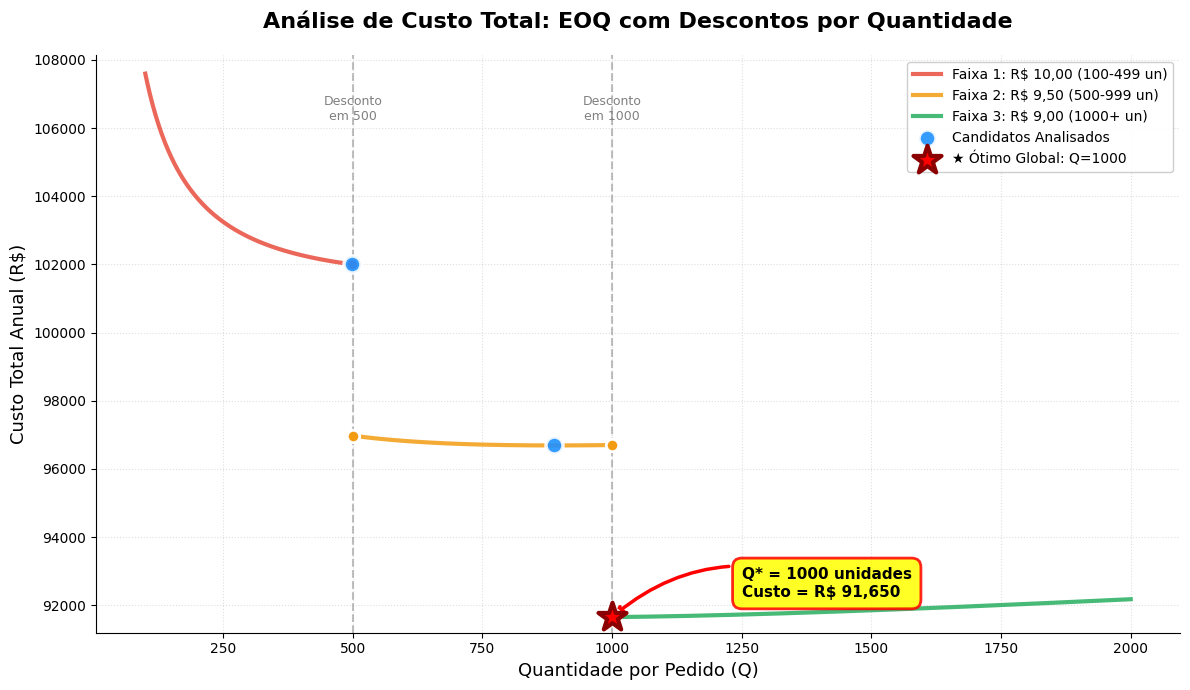

In [40]:
# --- 3.1 Exibir a Recomendação Final ---

print("=" * 60)
print("RECOMENDAÇÃO FINAL (RESULTADO DA OTIMIZAÇÃO)")
print("=" * 60)
print(f"O Lote Econômico de Compra (Q*) ÓTIMO é: {best_Q:.0f} unidades")
print(f"Este valor foi encontrado na faixa de preço de R$ {best_Tier['price']:.2f}")
print(f"O Custo Total Anual Mínimo será de: R$ {best_Cost:,.2f}")
print("=" * 60)

# --- 3.2 Preparar Dados para o Gráfico ---

print("\nGerando gráfico de custo (visualização da solução)...")

plt.figure(figsize=(12, 7))

# --- 3.3 Plotar CADA FAIXA DE PREÇO COMO CURVA SEPARADA ---
# Isso evita a conexão artificial entre faixas diferentes

# Faixa 1: 100 a 499 unidades (Preço R$ 10.00)
Q_faixa1 = np.linspace(100, 499, 200)
custos_faixa1 = []
for q in Q_faixa1:
    P1 = price_tiers[0]['price']
    H1 = P1 * holding_rate
    custos_faixa1.append(calculate_total_cost(q, D_val, S_val, H1, P1))

plt.plot(Q_faixa1, custos_faixa1, color='#E74C3C', lw=3, label='Faixa 1: R$ 10,00 (100-499 un)', alpha=0.85)

# Faixa 2: 500 a 999 unidades (Preço R$ 9.50)
Q_faixa2 = np.linspace(500, 999, 200)
custos_faixa2 = []
for q in Q_faixa2:
    P2 = price_tiers[1]['price']
    H2 = P2 * holding_rate
    custos_faixa2.append(calculate_total_cost(q, D_val, S_val, H2, P2))

plt.plot(Q_faixa2, custos_faixa2, color='#F39C12', lw=3, label='Faixa 2: R$ 9,50 (500-999 un)', alpha=0.85)

# Faixa 3: 1000 a 2000 unidades (Preço R$ 9.00)
Q_faixa3 = np.linspace(1000, 2000, 200)
custos_faixa3 = []
for q in Q_faixa3:
    P3 = price_tiers[2]['price']
    H3 = P3 * holding_rate
    custos_faixa3.append(calculate_total_cost(q, D_val, S_val, H3, P3))

plt.plot(Q_faixa3, custos_faixa3, color='#27AE60', lw=3, label='Faixa 3: R$ 9,00 (1000+ un)', alpha=0.85)

# --- Adicionar pontos nas transições para mostrar a descontinuidade ---
# Ponto final da Faixa 1 (Q=499)
custo_499 = calculate_total_cost(499, D_val, S_val, price_tiers[0]['price'] * holding_rate, price_tiers[0]['price'])
plt.scatter([499], [custo_499], color='#E74C3C', s=80, zorder=4, edgecolor='white', linewidth=2)

# Ponto inicial da Faixa 2 (Q=500)
custo_500 = calculate_total_cost(500, D_val, S_val, price_tiers[1]['price'] * holding_rate, price_tiers[1]['price'])
plt.scatter([500], [custo_500], color='#F39C12', s=80, zorder=4, edgecolor='white', linewidth=2)

# Ponto final da Faixa 2 (Q=999)
custo_999 = calculate_total_cost(999, D_val, S_val, price_tiers[1]['price'] * holding_rate, price_tiers[1]['price'])
plt.scatter([999], [custo_999], color='#F39C12', s=80, zorder=4, edgecolor='white', linewidth=2)

# Ponto inicial da Faixa 3 (Q=1000)
custo_1000 = calculate_total_cost(1000, D_val, S_val, price_tiers[2]['price'] * holding_rate, price_tiers[2]['price'])
plt.scatter([1000], [custo_1000], color='#27AE60', s=80, zorder=4, edgecolor='white', linewidth=2)

# --- Destacar as fronteiras de desconto ---
plt.axvline(x=500, color='gray', linestyle='--', lw=1.5, alpha=0.5)
plt.axvline(x=1000, color='gray', linestyle='--', lw=1.5, alpha=0.5)

# Adicionar texto nas fronteiras
plt.text(500, plt.ylim()[1] * 0.98, 'Desconto\nem 500', ha='center', fontsize=9, color='gray')
plt.text(1000, plt.ylim()[1] * 0.98, 'Desconto\nem 1000', ha='center', fontsize=9, color='gray')

# --- Destacar os pontos candidatos ---
candidates_q = [r['Q_candidate'] for r in results]
candidates_cost = [r['Cost_candidate'] for r in results]

plt.scatter(candidates_q, candidates_cost, color='dodgerblue', s=150, zorder=6, 
            edgecolors='white', linewidth=2.5, label='Candidatos Analisados', alpha=0.9)

# --- Destacar o PONTO ÓTIMO GLOBAL ---
plt.scatter(best_Q, best_Cost, color='red', s=450, zorder=10, 
            edgecolor='darkred', linewidth=3, marker='*', 
            label=f'★ Ótimo Global: Q={best_Q:.0f}')

# Adicionar anotação no ponto ótimo
plt.annotate(f'Q* = {best_Q:.0f} unidades\nCusto = R$ {best_Cost:,.0f}',
             xy=(best_Q, best_Cost), 
             xytext=(best_Q + 250, best_Cost + 600),
             fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.6', facecolor='yellow', alpha=0.85, edgecolor='red', linewidth=2),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', 
                           color='red', lw=2.5))

# --- Customização Final ---
plt.title('Análise de Custo Total: EOQ com Descontos por Quantidade', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Quantidade por Pedido (Q)', fontsize=13)
plt.ylabel('Custo Total Anual (R$)', fontsize=13)
plt.legend(loc='upper right', fontsize=10, framealpha=0.95)
plt.grid(True, linestyle=':', alpha=0.4)

# Ajustar os limites do eixo Y
all_costs = custos_faixa1 + custos_faixa2 + custos_faixa3
y_min = min(all_costs) * 0.995
y_max = max(all_costs) * 1.005
plt.ylim(bottom=y_min, top=y_max)

# Melhorar a aparência
sns.despine()
plt.tight_layout()
plt.show()

### Interpretação do Gráfico

Este gráfico mostra a análise de custo total considerando os descontos por quantidade:

1.  **Curva Vermelha (Faixa 1):** Custo quando o preço é R$ 10,00 por unidade (compras de 100-499 unidades)
2.  **Curva Laranja (Faixa 2):** Custo quando o preço cai para R$ 9,50 por unidade (compras de 500-999 unidades)
3.  **Curva Verde (Faixa 3):** Custo quando o preço cai para R$ 9,00 por unidade (compras de 1000+ unidades)

**Por que as curvas "pulam" para baixo nas fronteiras (500 e 1000)?**

Isso acontece porque quando você atinge essas quantidades, você **ganha um desconto no preço unitário**, o que faz o custo total cair. Por exemplo:
- Comprar 499 unidades a R$ 10,00 = custo maior
- Comprar 500 unidades a R$ 9,50 = custo menor (mesmo comprando mais!)

Essa "queda" é real e desejável - é o benefício do desconto por quantidade!

**Pontos Importantes:**
- 🔵 **Pontos Azuis:** Candidatos analisados (mínimos locais + fronteiras)
- ⭐ **Estrela Vermelha:** O ponto ótimo global que minimiza o custo total
- As linhas cinzas verticais marcam onde os descontos começam

### Exemplo Numérico: Por que o custo "cai" nas fronteiras?

Vamos calcular o custo para entender melhor o "salto" que vemos no gráfico:

In [41]:
# Vamos comparar o custo de comprar 499 unidades vs 500 unidades

print("=" * 70)
print("COMPARAÇÃO: Efeito do Desconto na Fronteira de 500 unidades")
print("=" * 70)

# Cenário 1: Comprar 499 unidades (preço R$ 10,00)
Q1 = 499
P1 = 10.00
H1 = P1 * holding_rate
custo_499 = calculate_total_cost(Q1, D_val, S_val, H1, P1)

print(f"\n📦 Comprar {Q1} unidades (Faixa 1):")
print(f"   Preço unitário: R$ {P1:.2f}")
print(f"   Custo de Estocagem (H): R$ {H1:.2f}")
print(f"   → Custo Total Anual: R$ {custo_499:,.2f}")

# Cenário 2: Comprar 500 unidades (preço R$ 9,50 - COM DESCONTO!)
Q2 = 500
P2 = 9.50
H2 = P2 * holding_rate
custo_500 = calculate_total_cost(Q2, D_val, S_val, H2, P2)

print(f"\n📦 Comprar {Q2} unidades (Faixa 2 - COM DESCONTO):")
print(f"   Preço unitário: R$ {P2:.2f}")
print(f"   Custo de Estocagem (H): R$ {H2:.2f}")
print(f"   → Custo Total Anual: R$ {custo_500:,.2f}")

# Diferença
diferenca = custo_499 - custo_500
print(f"\n💰 ECONOMIA ao atingir o desconto: R$ {diferenca:,.2f}")
print(f"   Mesmo comprando MAIS unidades, o custo DIMINUI em {(diferenca/custo_499)*100:.1f}%!")

print("=" * 70)
print("\n✅ Conclusão: A 'queda' no gráfico é REAL e BENÉFICA!")
print("   Ela representa a economia obtida ao atingir a faixa de desconto.")
print("=" * 70)

COMPARAÇÃO: Efeito do Desconto na Fronteira de 500 unidades

📦 Comprar 499 unidades (Faixa 1):
   Preço unitário: R$ 10.00
   Custo de Estocagem (H): R$ 2.00
   → Custo Total Anual: R$ 102,002.01

📦 Comprar 500 unidades (Faixa 2 - COM DESCONTO):
   Preço unitário: R$ 9.50
   Custo de Estocagem (H): R$ 1.90
   → Custo Total Anual: R$ 96,975.00

💰 ECONOMIA ao atingir o desconto: R$ 5,027.01
   Mesmo comprando MAIS unidades, o custo DIMINUI em 4.9%!

✅ Conclusão: A 'queda' no gráfico é REAL e BENÉFICA!
   Ela representa a economia obtida ao atingir a faixa de desconto.
